/tmp/ipython-input-1544210148.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period='1y')['Close']
[*********************100%***********************]  2 of 2 completed


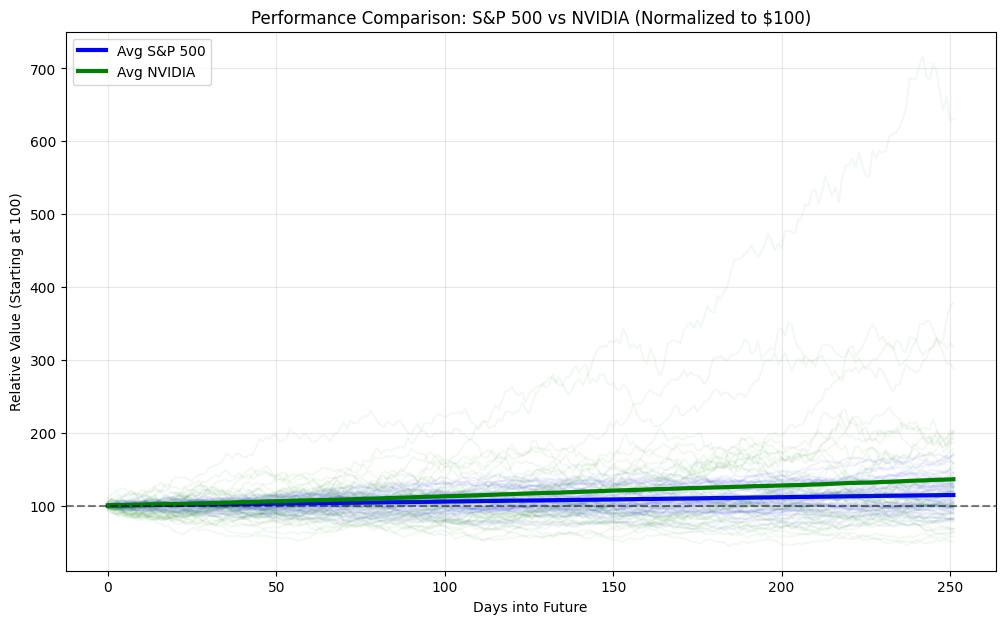


--- PERFORMANCE DIAGNOSTICS ---
        Actual Start Price Exp. % Return (1yr) Prob. of Profit  \
S&P 500           $6909.79               14.5%           73.0%   
NVIDIA             $189.21               36.2%           64.6%   

        95% Max Loss (VaR) Volatility (Annual) Sharpe Ratio  
S&P 500             -17.3%               18.7%         0.56  
NVIDIA              -46.7%               50.0%         0.64  


In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1. Setup
tickers = ['^GSPC', 'NVDA']
days = 252
n_sims = 5000
start_value = 100  # Scaling both to 100 for visual clarity
risk_free_rate = 0.04  # <--- NEW: Standard Risk-Free Rate (4%)

# 2. Get Data
data = yf.download(tickers, period='1y')['Close']
returns = np.log(data / data.shift(1)).dropna()

results_summary = {}
plt.figure(figsize=(12, 7))

# 3. Simulation Loop
for ticker in tickers:
    mu = returns[ticker].mean()
    sigma = returns[ticker].std()
    real_S0 = data[ticker].iloc[-1]

    # Simulate based on 100 starting value
    random_shocks = np.random.normal(0, 1, (days, n_sims))
    daily_growth = np.exp((mu - 0.5 * sigma**2) + sigma * random_shocks)

    # Path starting from 100
    normalized_paths = start_value * daily_growth.cumprod(axis=0)

    # Calculate Stats
    final_vals = normalized_paths[-1]

    # --- NEW: SHARPE RATIO CALCULATION ---
    # Convert annual return and volatility to decimals for the math
    exp_return_decimal = (final_vals.mean() - start_value) / start_value
    ann_vol_decimal = sigma * np.sqrt(252)

    # Formula: (Return - RiskFree) / Volatility
    sharpe_ratio = (exp_return_decimal - risk_free_rate) / ann_vol_decimal
    # -------------------------------------

    prob_profit = (final_vals > start_value).mean() * 100
    var_95_val = np.percentile(final_vals, 5)
    pct_risk = ((var_95_val - start_value) / start_value) * 100

    name = "S&P 500" if ticker == '^GSPC' else "NVIDIA"
    results_summary[name] = {
        "Actual Start Price": f"${real_S0:.2f}",
        "Exp. % Return (1yr)": f"{(exp_return_decimal * 100):.1f}%",
        "Prob. of Profit": f"{prob_profit:.1f}%",
        "95% Max Loss (VaR)": f"{pct_risk:.1f}%",
        "Volatility (Annual)": f"{(ann_vol_decimal * 100):.1f}%",
        "Sharpe Ratio": f"{sharpe_ratio:.2f}" # <--- ADDED TO SUMMARY
    }

    # Plotting
    color = 'blue' if ticker == '^GSPC' else 'green'
    plt.plot(normalized_paths[:, :50], color=color, alpha=0.05)
    plt.plot(normalized_paths.mean(axis=1), color=color, label=f'Avg {name}', linewidth=3)

# 4. Final Formatting
plt.axhline(100, color='black', linestyle='--', alpha=0.5)
plt.title("Performance Comparison: S&P 500 vs NVIDIA (Normalized to $100)")
plt.ylabel("Relative Value (Starting at 100)")
plt.xlabel("Days into Future")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n--- PERFORMANCE DIAGNOSTICS ---")
print(pd.DataFrame(results_summary).T)